# Implementatioin of Artificial Potential Field Algorithm for static obstacles


In [140]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [141]:
# Generate sample points
rows = 600
cols = 800

obs_space = np.zeros((rows, cols))
[x,y] = np.meshgrid(np.linspace(0, cols, cols), np.linspace(0, rows, rows))

# Creating obstacles 
obs_space[30:100, 30:100] = 1
obs_space[250:350, 450:600] = 1
obs_space[400:500, 700:750] = 1

a = ((x - 130)**2 + (y - 450)**2) <= 100**2
obs_space[a] = 1

b = ((x - 300)**2 + (y - 300)**2) <= 70**2
obs_space[b] = 1



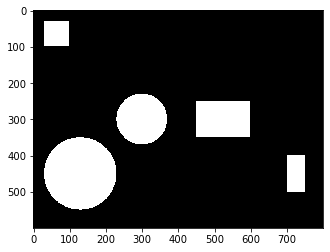

In [142]:
plt.imshow(obs_space, cmap='gray')

Text(0.5, 1.0, 'Repulsive Potential')

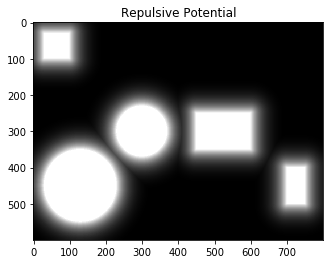

In [143]:
# Now we use the scipy distance transform to compute the distance from non-zero points to the nearest zero point(obstacles)
from scipy.ndimage.morphology import distance_transform_edt as dt

dist = dt(obs_space==0)

# We apply repulsive potential to the points that are close to the obstacles
eta = 800
row_x = (dist/100) + 1
d_0 = 2

# Calculating the repulsive potential
repulsive = eta * ((1/row_x) - (1/d_0))**2

# If the point is close to the obstacle, we set the repulsive potential to zero
repulsive[row_x > d_0] = 0


plt.imshow(repulsive, cmap='gray')
plt.title('Repulsive Potential')

Text(0.5, 1.0, 'Attractive Potential')

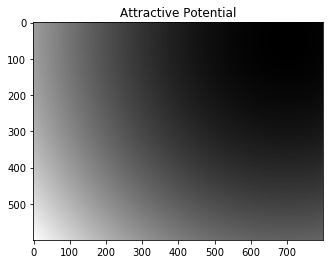

In [144]:
# Now we apply attractive potential to the points that are close to the goal

goal = [700,50]

attractive = (1/eta) * ((x - goal[0])**2 + (y - goal[1])**2)

plt.imshow(attractive, cmap='gray')
plt.title('Attractive Potential')

Text(0.5, 1.0, 'Start and Goal Points')

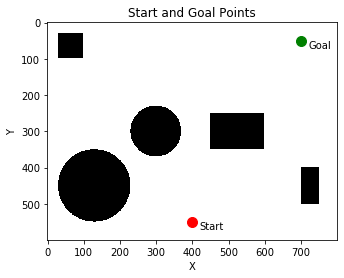

In [145]:
start = [400,550]

plt.imshow(1 - obs_space, cmap='gray') # To show the start and goal points
plt.plot(start[0], start[1], 'ro', color = 'red',markersize=10)
plt.plot(goal[0], goal[1], 'go',color = 'green', markersize=10)
plt.annotate('Start', xy=(start[0], start[1]), xytext=(start[0]+20, start[1]+20))
plt.annotate('Goal', xy=(goal[0], goal[1]), xytext=(goal[0]+20, goal[1]+20))
plt.xlabel('X')
plt.ylabel('Y')

plt.title('Start and Goal Points')




Text(0.5, 1.0, 'Attractive Potential + Repulsive Potential')

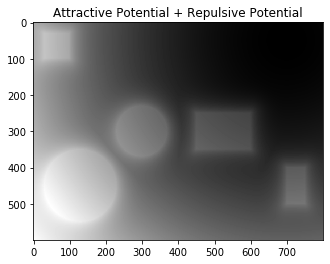

In [146]:
# Now we combine the repulsive and attractive potentials

apf = attractive + repulsive
plt.imshow(apf, cmap='gray')
plt.title('Attractive Potential + Repulsive Potential')

In [147]:
def gradient_planner(start, goal, obstacles, eta, d_0,n_iters):
    """
    @brief: This function will generate a path from start to goal using the APF algorithm.
    @param start: The start position of the robot
    @param goal: The goal position of the robot
    @param obstacles: The obstacles in the environment
    @param eta: The attractive potential parameter
    @param d_0: The repulsive potential parameter
    @param n_iters: The number of iterations to run the algorithm
    @return: The path from start to goal
    """
    

    
    dist = dt(obstacles==0)
    row_x = (dist/100) + 1
    attractive = (1/eta) * ((x - goal[0])**2 + (y - goal[1])**2)
    repulsive = eta * ((1/row_x) - (1/d_0))**2
    repulsive[row_x > d_0] = 0
    
    apf = attractive + repulsive
    
    # Now we find the gradient of the potential field at each point
    # We reach the gradient at each point by subtracting the potential field at the point from the potential field at the next point.
    
    # To reach the goal we need to find the gradient of the potential field at the goal point.
    
    [f_y,f_x] = np.gradient(-apf)
    
    path = np.vstack([np.array(start), np.array(start)])
    
    for i in range(n_iters):
        current_cell = path[-1,:]
        if(sum(abs(current_cell - goal)) < 0.01):
            print('Goal Reached')
            break
        # We find the gradient at the current cell
        i_x,i_y = int(round(current_cell[1])), int(round(current_cell[0]))
        v_x = f_x[i_x,i_y]
        v_y = f_y[i_x,i_y]
        d_t =1/np.linalg.norm([v_x,v_y])
        next_cell = current_cell + d_t * np.array([v_x,v_y])
        path = np.vstack([path, next_cell])
    path = path[1:,:]
    
    fig , ax = plt.subplots(2,2)
    ax[0,0].imshow(obs_space, cmap='gray')
    ax[0,0].plot(start[0], start[1], 'ro', color = 'red',markersize=10) 
    ax[0,0].plot(goal[0], goal[1], 'go',color = 'green', markersize=10)

    ax[0,1].imshow(apf, cmap='gray')
    ax[0,1].plot(start[0], start[1], 'ro', color = 'red',markersize=10)
    ax[0,1].plot(goal[0], goal[1], 'go',color = 'green', markersize=10) 
    
    ax[1,0].imshow(f_y, cmap='gray')
    ax[1,0].set_title('Gradient in Y')
    
    ax[1,1].imshow(f_x, cmap='gray')
    ax[1,1].set_title('Gradient in X')
        
    
    return path


   

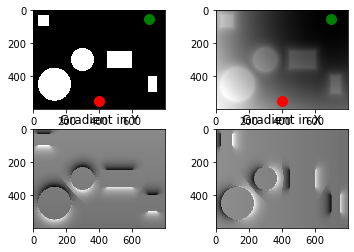

In [148]:
path = gradient_planner(start, goal, obs_space, eta, d_0, n_iters=600)


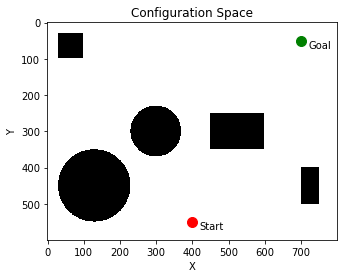

In [149]:
def show_cspace():
    plt.imshow(1 - obs_space, cmap='gray') # To show the start and goal points
    plt.plot(start[0], start[1], 'ro', color = 'red',markersize=10)
    plt.plot(goal[0], goal[1], 'go',color = 'green', markersize=10)
    plt.annotate('Start', xy=(start[0], start[1]), xytext=(start[0]+20, start[1]+20))
    plt.annotate('Goal', xy=(goal[0], goal[1]), xytext=(goal[0]+20, goal[1]+20))
    plt.xlabel('X')
    plt.ylabel('Y')

    plt.title('Configuration Space')
    
show_cspace()

In [150]:
def grad_quiver_plot(x,y,f_x,f_y):
    jump = 5
    plt.figure(figsize=(10,10))
    q = plt.quiver(x[::jump,::jump], y[::jump,::jump], f_x[::jump,::jump], f_y[::jump,::jump],pivot='mid', units='inches')
    q_key = plt.quiverkey(q, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='E', coordinates='figure')
    

Text(0, 0.5, 'Y')

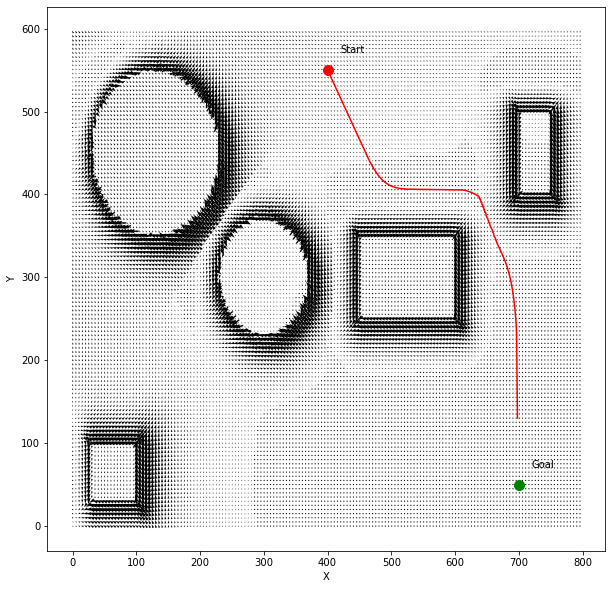

In [155]:
[f_x,f_y] = np.gradient(-apf)
grad_quiver_plot(x,y,f_x,f_y)

plt.plot(start[0], start[1], 'ro', color = 'red',markersize=10)
plt.plot(goal[0], goal[1], 'go',color = 'green', markersize=10)
plt.annotate('Start', xy=(start[0], start[1]), xytext=(start[0]+20, start[1]+20))
plt.annotate('Goal', xy=(goal[0], goal[1]), xytext=(goal[0]+20, goal[1]+20))
plt.plot(path[:,0], path[:,1], 'r-')
plt.xlabel('X')
plt.ylabel('Y')